In [902]:
import sys
import pandas as pd
import numpy as np

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [798]:
data_raw = pd.read_csv('C:/Users/ZHAOFENG SHANG/Desktop/RUcourses/Semester2/Algorithm_learning/Final project/train.csv')

data_val = pd.read_csv('C:/Users/ZHAOFENG SHANG/Desktop/RUcourses/Semester2/Algorithm_learning/Final project/test.csv')

data1 = data_raw.copy(deep = True)

In [799]:
data_cleaner = [data1, data_val]

In [800]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


# Exploratory Data Analysis

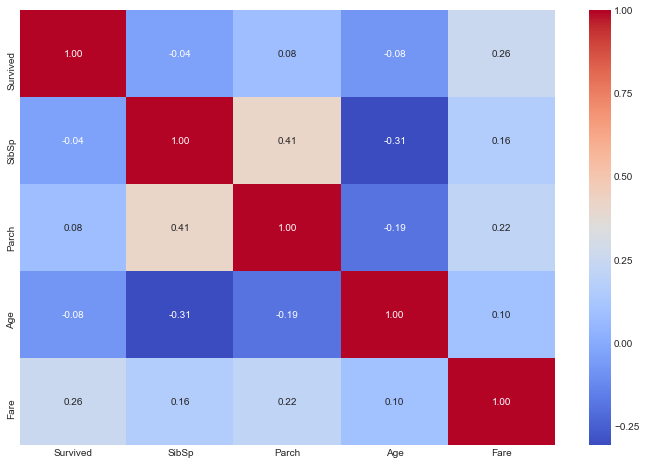

In [801]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(data_raw[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# SibSP

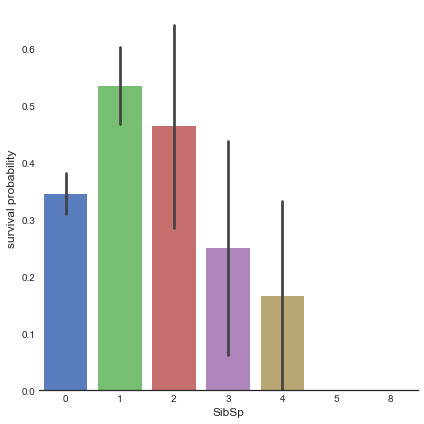

In [802]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=data_raw,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")
# It seems that passengers having a lot of siblings/spouses have less chance to survive

# Single passengers (0 SibSP) or with two other persons (SibSP 1 or 2) have more chance to survive

# Parch

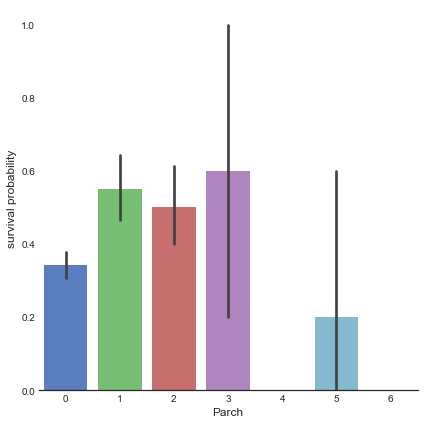

In [803]:
# Explore Parch feature vs Survived
g  = sns.factorplot(x="Parch",y="Survived",data=data_raw,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

# Age

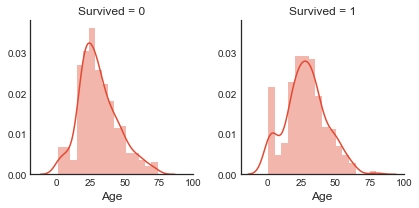

In [804]:

# Explore Age vs Survived
g = sns.FacetGrid(data_raw, col='Survived')
g = g.map(sns.distplot, "Age")

# 4C in Correcting
# Outliers

In [805]:
from collections import Counter
def detect_outliers(df,n,features):

    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    
    # select observations(a row) containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        

    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(data_raw,2,["Age","SibSp","Parch","Fare"])

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\numpy\lib\function_base.py:4274: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [806]:
data_raw.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [807]:
# after detect all outliers, we need drop them in the train dataset.
data_raw.drop(Outliers_to_drop, axis=0, inplace=True)

In [808]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


# Join the train and test together

In [809]:
dataset = pd.concat([data_raw,data_val],axis=0).reset_index(drop=True)

In [810]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450



# 4C in Correcting
# Standardization


In [811]:
dataset[dataset['Fare'].isnull()==True]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1033,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [812]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

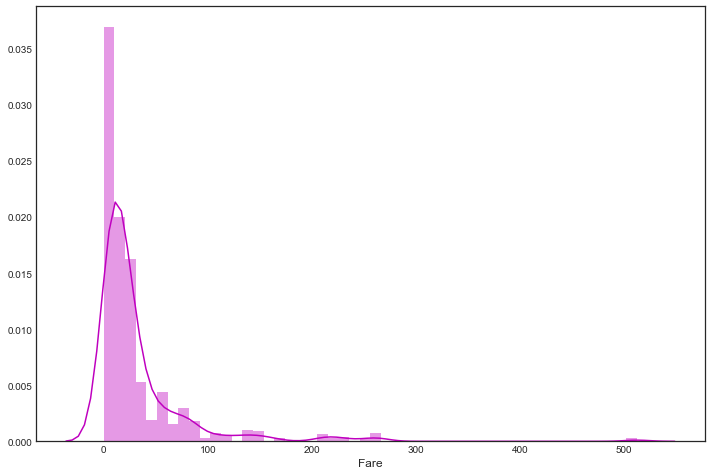

In [813]:
# Explore Fare distribution.

graph = sns.distplot(dataset['Fare'], color='m', label='sKewness: %.2f' %(dataset['Fare'].skew()))

In [814]:
# As we can see, Fare distribution is very skewed. This can lead to overweigth very high values in the model, even if it is scaled.

# In this case, it is better to transform it with the log function to reduce this skew.

In [815]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

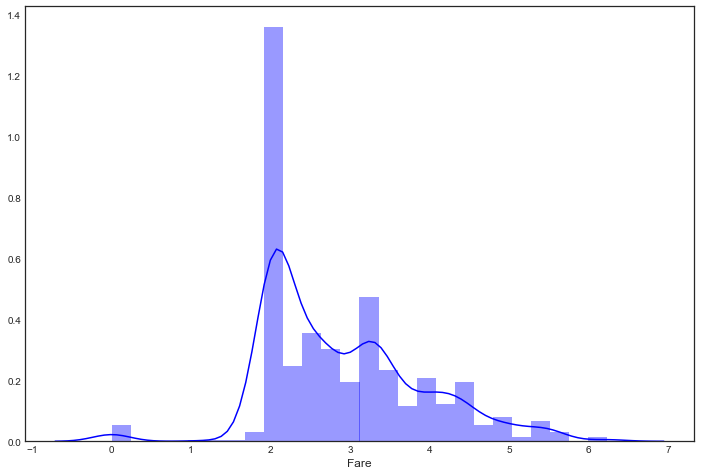

In [816]:
graph = sns.distplot(dataset['Fare'], color='b', label='sKewness: %.2f' %(dataset['Fare'].skew()))

# 4C in Completing
# Missing value

In [817]:
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [818]:
# Survived column doesn't exist in test 
# set and has been replace by NaN values when concatenating the train and test set

In [819]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# deal with the Embarked missing value:

In [820]:
def fill_missing_embarked(data):
    freq_port = data['Embarked'].mode()[0]
    data['Embarked'] = data['Embarked'].fillna(freq_port)
    data['Embarked'] = data['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
    return data

dataset = fill_missing_embarked(dataset)


# deal with Cabin missing values

In [821]:
# because the attribute "Cabin" has too much missing values, so delete this attribute.

In [822]:
dataset.drop(labels='Cabin',axis=1,inplace=True)

# deal with Age missing values

In [823]:
# The age attribute has 256 missing values. To fill the missing age value, it's better to built a 
# model with related attributes rather than just use the mode()、median() functions.
# In the first place, the following graph will show the relationship between 
# Age (Sex, Parch , Pclass and SibSP)

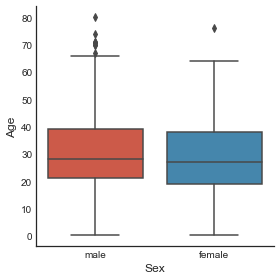

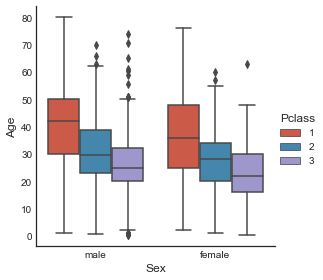

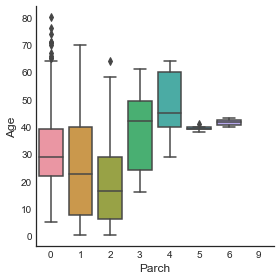

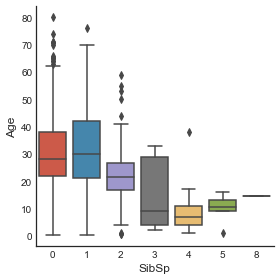

In [824]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [825]:
# from the above graph, Age distribution seems to be the same in Male and Female subpopulations, 
# so Sex is not informative to predict Age.
# then, we need built the correlation matrix to have a deer understanding.

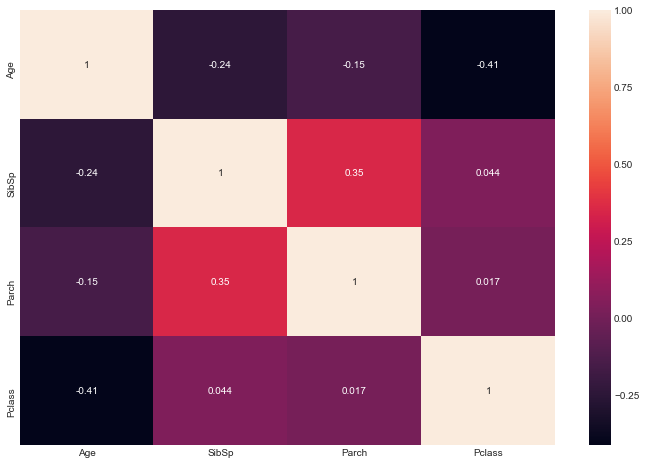

In [826]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True)

In [827]:
# The Strategy is to fill Age with the median number of similar rows according to Plcass, 
# Parch and SibSp. If model can't find such rows, then fill the age with the median number of 
# same title(This is a created attribtes), because the title has no missing values.

In [828]:
# to do that, we need create the "title" attribute in the first palce . This should be the 
# Creating part( Feature engineering), but we need ahead of schedule

In [829]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

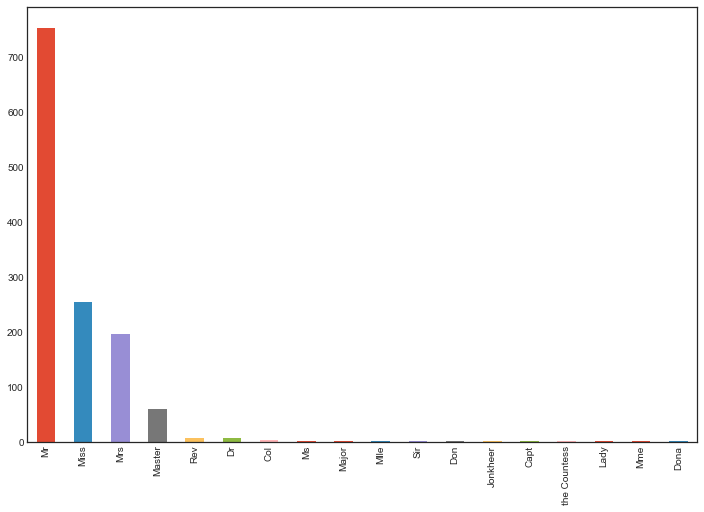

In [830]:
# Get the title from the name
title_club = [i.split(",")[1].split(".")[0].strip() for i in dataset['Name']]
title_club = pd.Series(title_club)
title_club.value_counts().plot(kind='bar')

In [831]:
#  extract all Mr Miss. etc
def name_extract(data):
    # extract Title from name
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # delete rare title
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_map).astype(int)
                                            
    return data.drop('Name', axis=1) 



dataset = name_extract(dataset)

In [832]:
# after get the attribute 'title', we can finish the age_missing_fill function
# Filling missing value of Age 

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
def missing_age(data):
    data_not = dataset[dataset.Age.notnull()]
    
    age_null = list(data[data['Age'].isnull()].index)
    print(len(age_null))
    for i in age_null:
        age_pred=np.nan
        age_pred = data_not['Age'][((data_not['SibSp']==data.iloc[i]['SibSp'])&(data_not['Parch'] == data.iloc[i]["Parch"]) &
                                    (data_not['Pclass'] == data["Pclass"].iloc[i]))].median()
        
        if np.isnan(age_pred):
            data['Age'].iloc[i] = data_not['Age'][data_not['Title']==data['Title'].iloc[i]].median()
        else:
            data['Age'].iloc[i] = age_pred
    return data
    

In [833]:
dataset=missing_age(dataset)

256


c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# 4C in Converting
# Dummy Variables

In [834]:
# The attribute “Embarked” has three categorical values S, Q and C. 
# The function below is to change the categorical values into numerical values by using Dummy.

In [835]:
def dummy(data, columns):  # temporarily just for Embarked
    for column in columns:
        if column not in data.columns:
            continue
        dummy_data = pd.get_dummies(data[column], drop_first=False,prefix='Embarked')

        data = pd.concat([data, dummy_data], axis=1)

        data = data.drop(column, axis=1)
    return data

In [836]:
dataset = dummy(dataset, ['Embarked'])


In [837]:
# the pclass has three different values


In [838]:
# dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")
# this part will do in the below code

In [839]:
# treat with Sex attribute
def SexByPclass(data):
    data['Sex'] = data['Sex'].map({'female': 1, 'male':0})
    return data
dataset = SexByPclass(dataset)

# Factorization

In [840]:
# After filling all missing values,
# the function above changed the “Age” value into four intervals according to the quartile value.

In [841]:
dataset['Age'].describe()

count    1299.000000
mean       29.284580
std        13.271548
min         0.170000
25%        22.000000
50%        26.000000
75%        37.000000
max        80.000000
Name: Age, dtype: float64

In [842]:
def age_extract(data):

    data.loc[data['Age'] <= 22, 'Age'] = 1
    data.loc[(data['Age'] <= 26) & (data['Age'] > 22), 'Age'] = 2
    data.loc[(data['Age'] <=37 ) & (data['Age'] > 26), 'Age'] = 3
    data.loc[data['Age'] > 37, 'Age'] = 4
    data['Age'] = data['Age'].astype(int)
    return data

In [843]:
dataset = age_extract(dataset)

In [844]:
dataset

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Embarked_0,Embarked_1,Embarked_2
0,1,1.981001,0,1,3,0,1,0.0,A/5 21171,1,1,0,0
1,4,4.266662,0,2,1,1,1,1.0,PC 17599,3,0,0,1
2,2,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,2,1,0,0
3,3,3.972177,0,4,1,1,1,1.0,113803,3,1,0,0
4,3,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0
5,2,2.135148,0,6,3,0,0,0.0,330877,1,0,1,0
6,4,3.948596,0,7,1,0,0,0.0,17463,1,1,0,0
7,1,3.048088,1,8,3,0,3,0.0,349909,4,1,0,0
8,3,2.409941,2,9,3,1,0,1.0,347742,3,1,0,0
9,1,3.403555,0,10,2,1,1,1.0,237736,3,0,0,1


# 4C in Creating
# Fare_Stage

In [845]:
# Here, deal with the Fare, combine the train and test dataset of mean to discretized values
def fare_stage(data, mean_fare):
    data.loc[data['Fare'] > mean_fare[1], 'FareStage'] = 1
    data.loc[(data['Fare'] > mean_fare[2]) & (data['Fare'] <= mean_fare[1]), 'FareStage'] = 2
    data.loc[(data['Fare'] > mean_fare[3]) & (data['Fare'] <= mean_fare[2]), 'FareStage'] = 3
    data.loc[data['Fare'] <=mean_fare[3],'FareStage'] = 4
    return data

mean_fare = dataset.groupby('Pclass')['Fare'].mean().astype(int)
print(mean_fare)
dataset = fare_stage(dataset, mean_fare)


Pclass
1    4
2    2
3    2
Name: Fare, dtype: int32


# Title

In [846]:
def name_extract(data):
    # extract Title from name
    data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
    # delete rare title
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

    title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_map).astype(int)
                                            
    return data.drop('Name', axis=1) 


In [847]:
def family_info(data):
    data['FamliySize'] = data['SibSp'] + data['Parch'] + 1
    data['Alone'] = data['Alone'] = (data['SibSp'] == 0) & (data['Parch'] == 0)
    data['Alone'] = data['Alone'].astype(int)
    return data
dataset = family_info(dataset)

In [848]:
dataset

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Embarked_0,Embarked_1,Embarked_2,FareStage,FamliySize,Alone
0,1,1.981001,0,1,3,0,1,0.0,A/5 21171,1,1,0,0,4.0,2,0
1,4,4.266662,0,2,1,1,1,1.0,PC 17599,3,0,0,1,1.0,2,0
2,2,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,2,1,0,0,2.0,1,1
3,3,3.972177,0,4,1,1,1,1.0,113803,3,1,0,0,2.0,2,0
4,3,2.085672,0,5,3,0,0,0.0,373450,1,1,0,0,2.0,1,1
5,2,2.135148,0,6,3,0,0,0.0,330877,1,0,1,0,2.0,1,1
6,4,3.948596,0,7,1,0,0,0.0,17463,1,1,0,0,2.0,1,1
7,1,3.048088,1,8,3,0,3,0.0,349909,4,1,0,0,2.0,5,0
8,3,2.409941,2,9,3,1,0,1.0,347742,3,1,0,0,2.0,3,0
9,1,3.403555,0,10,2,1,1,1.0,237736,3,0,0,1,2.0,2,0


# Ticket

In [849]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        

In [850]:
# dataset['Ticket']=Ticket
# dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [851]:
dataset=pd.get_dummies(dataset,columns=['Sex'])

In [852]:
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [853]:
dataset=dataset.drop(['Fare','PassengerId'],axis=1)

In [856]:
dataset

,Age,Parch,SibSp,Survived,Title,Embarked_0,Embarked_1,Embarked_2,FareStage,FamliySize,Alone,Sex_0,Sex_1,Pc_1,Pc_2,Pc_3
0,1,0,1,0.0,1,1,0,0,4.0,2,0,1,0,0,0,1
1,4,0,1,1.0,3,0,0,1,1.0,2,0,0,1,1,0,0
2,2,0,0,1.0,2,1,0,0,2.0,1,1,0,1,0,0,1
3,3,0,1,1.0,3,1,0,0,2.0,2,0,0,1,1,0,0
4,3,0,0,0.0,1,1,0,0,2.0,1,1,1,0,0,0,1
5,2,0,0,0.0,1,0,1,0,2.0,1,1,1,0,0,0,1
6,4,0,0,0.0,1,1,0,0,2.0,1,1,1,0,1,0,0
7,1,1,3,0.0,4,1,0,0,2.0,5,0,1,0,0,0,1
8,3,2,0,1.0,3,1,0,0,2.0,3,0,0,1,0,0,1
9,1,0,1,1.0,3,0,0,1,2.0,2,0,0,1,0,1,0


In [855]:
dataset=dataset.drop(['Ticket'],axis=1)

In [857]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 16 columns):
Age           1299 non-null int32
Parch         1299 non-null int64
SibSp         1299 non-null int64
Survived      881 non-null float64
Title         1299 non-null int32
Embarked_0    1299 non-null uint8
Embarked_1    1299 non-null uint8
Embarked_2    1299 non-null uint8
FareStage     1299 non-null float64
FamliySize    1299 non-null int64
Alone         1299 non-null int32
Sex_0         1299 non-null uint8
Sex_1         1299 non-null uint8
Pc_1          1299 non-null uint8
Pc_2          1299 non-null uint8
Pc_3          1299 non-null uint8
dtypes: float64(2), int32(3), int64(3), uint8(8)
memory usage: 76.2 KB


# Modeling

In [858]:
# Separate dataset into train and test set.
train=dataset[0:881]
test=dataset[881:]

In [859]:
test.drop(labels=['Survived'],axis=1,inplace=True)

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [860]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [861]:
Target = ['Survived']

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



In [862]:
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']


In [863]:
MLA_compare = pd.DataFrame(columns = MLA_columns)

In [864]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time


In [865]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )
row_index = 0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, X_train, y = Y_train, scoring = "accuracy", cv = cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    ##let's know the worst that can happen!
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare   
    

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=T

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.835417,0.825283,0.03824,0.0355513
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.828598,0.819623,0.0350029,0.047182
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.87178,0.812075,0.0374784,0.0836143
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.870455,0.811698,0.030566,0.225155
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.858523,0.810566,0.0452264,0.0401805
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.828788,0.809811,0.025415,0.0682071
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.897917,0.804528,0.0302923,0.0145634
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850379,0.803774,0.0501191,0.00250652
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.893182,0.803019,0.0394768,0.0171609
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.813258,0.8,0.0447134,0.0357076


Text(0,0.5,'Algorithm')

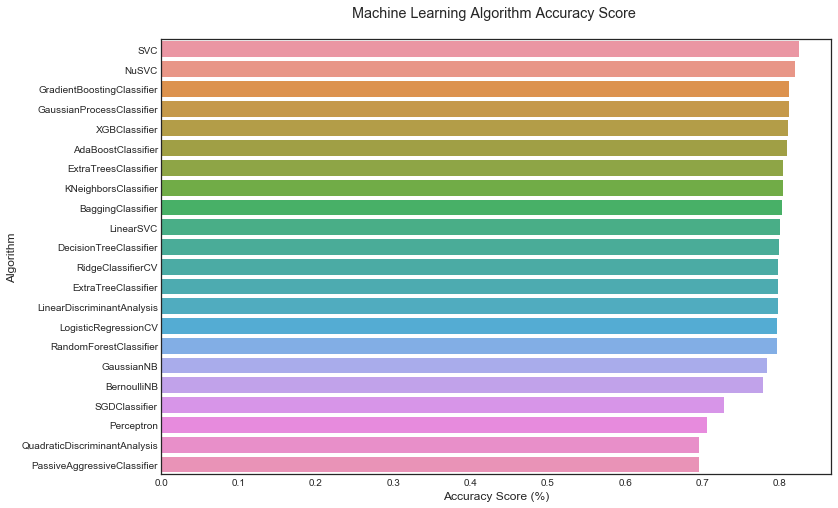

In [867]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare)

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [868]:
# After trying so many models above, Next job is to select some better model and tune model's Hyper-Parameters 

In [873]:
# select a basket of model

vote_set = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb', XGBClassifier())

]

In [874]:
#Hyperparameter Tune with GridSearchCV: 
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
        
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
            [{
            }],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]


In [892]:
# use the zip method to combine the model set vote_set and related parameter set grid_param.

In [896]:
for clf, param in zip(vote_set, grid_param):
    best_search = model_selection.GridSearchCV(estimator=clf[1], param_grid= param , cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X_train, Y_train)
#     gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
#     gsRFC.fit(X_train,Y_train)
#     RFC_best = gsRFC.best_estimator_
#     this is a way to apply the best parameter
    best_param = best_search.best_params_
    print(" the best param for {} is {} ".format(clf[1].__class__.__name__, best_param))
    print("***********************************************")
    # this is another way to apply
    clf[1].set_params(**best_param)
    
    

 the best param for AdaBoostClassifier is {'learning_rate': 0.25, 'n_estimators': 300, 'random_state': 0} 
***********************************************
 the best param for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} 
***********************************************
 the best param for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 300, 'random_state': 0} 
***********************************************
 the best param for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} 
***********************************************


c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(

 the best param for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} 
***********************************************


c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", Converge

 the best param for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'newton-cg'} 
***********************************************
 the best param for BernoulliNB is {'alpha': 0.1} 
***********************************************
 the best param for GaussianNB is {} 
***********************************************
 the best param for KNeighborsClassifier is {'algorithm': 'ball_tree', 'n_neighbors': 7, 'weights': 'uniform'} 
***********************************************
 the best param for SVC is {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.1, 'probability': True, 'random_state': 0} 
***********************************************
 the best param for XGBClassifier is {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} 
***********************************************


In [897]:
# After find all the best paramater, then plot the learning curves for every model
# Learning curves are a good way to see the overfitting effect on the training set 
# and the effect of the training size on the accuracy.

In [898]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

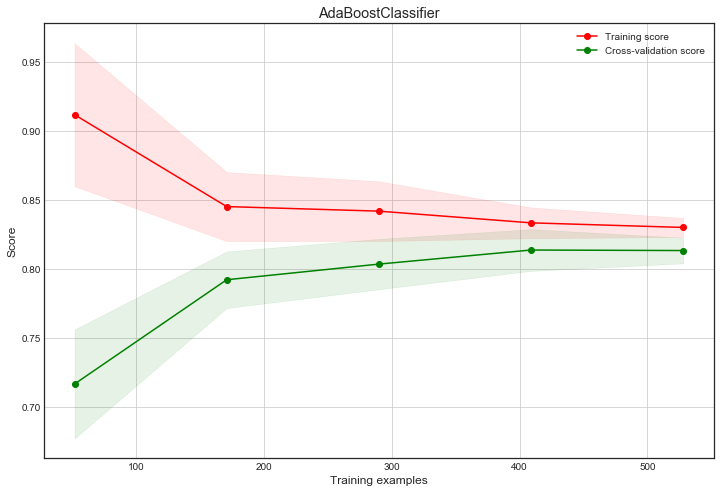

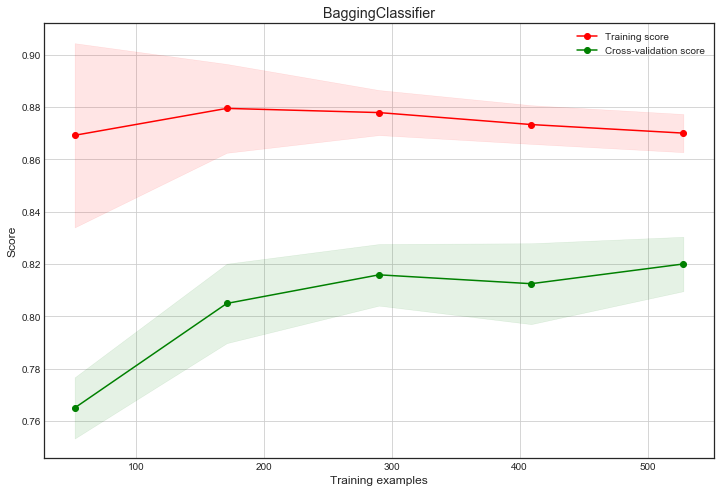

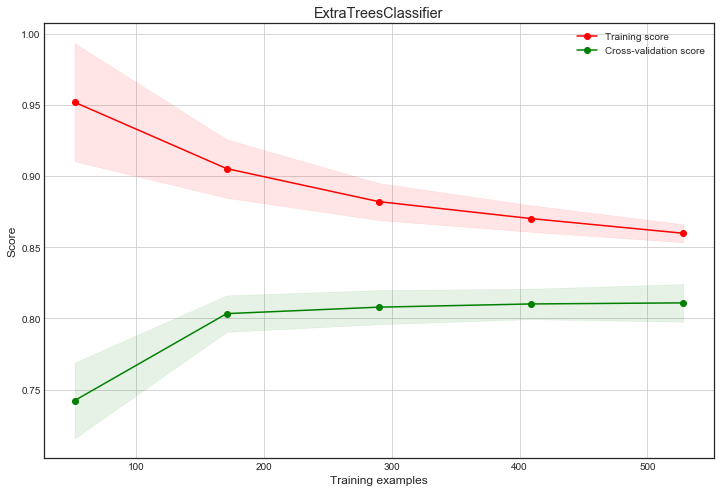

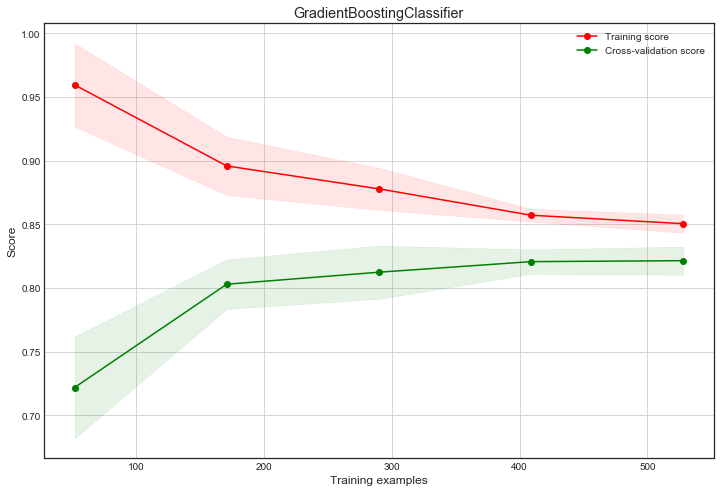

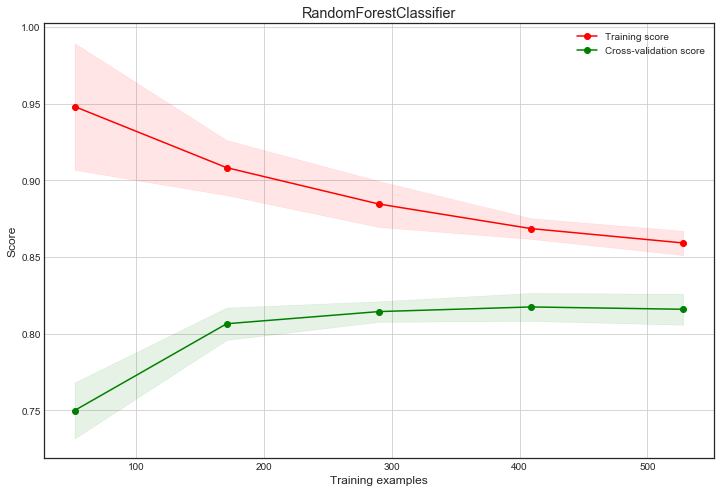

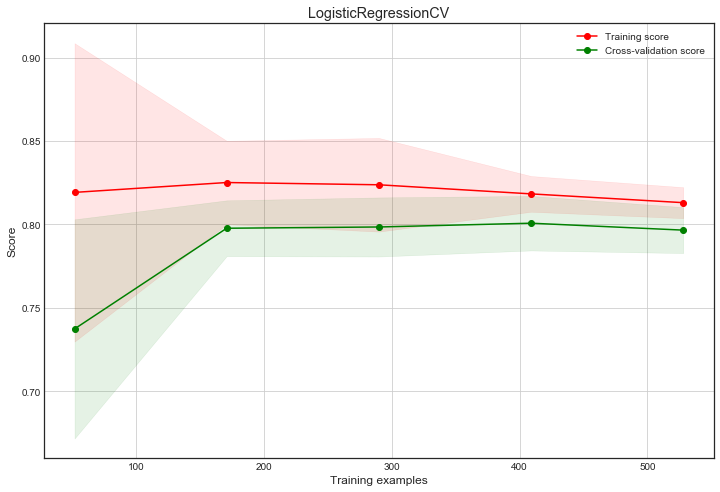

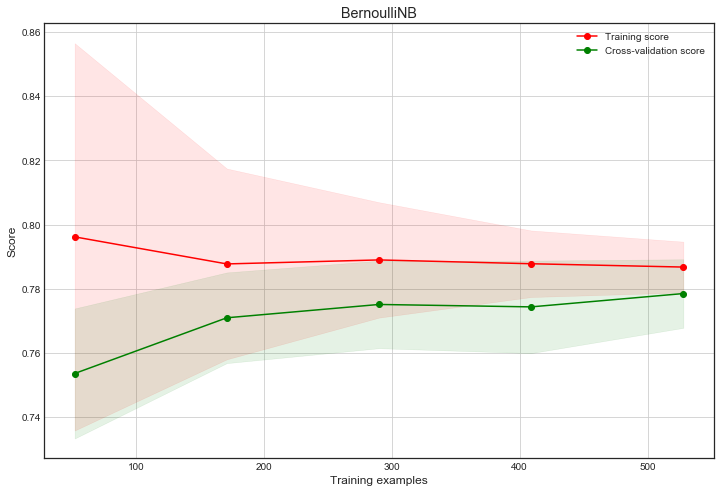

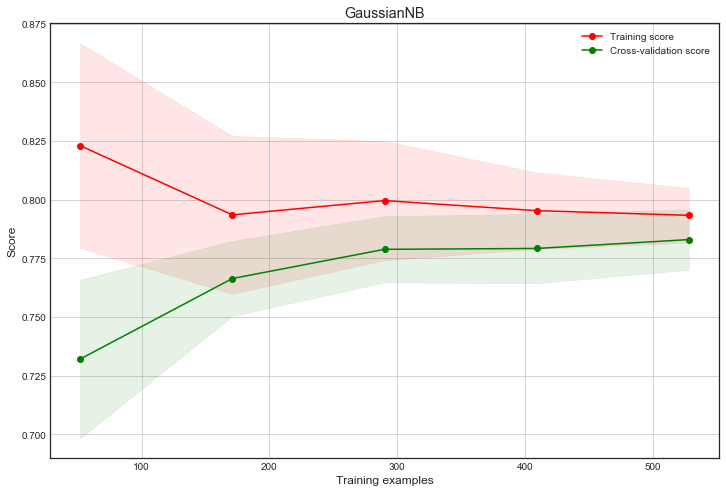

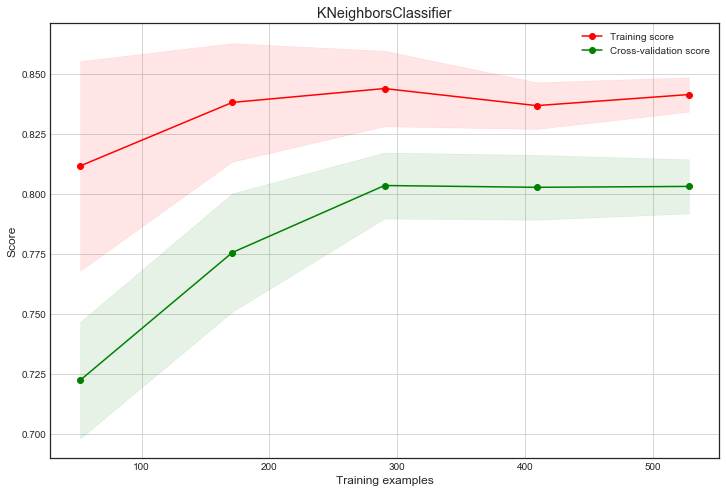

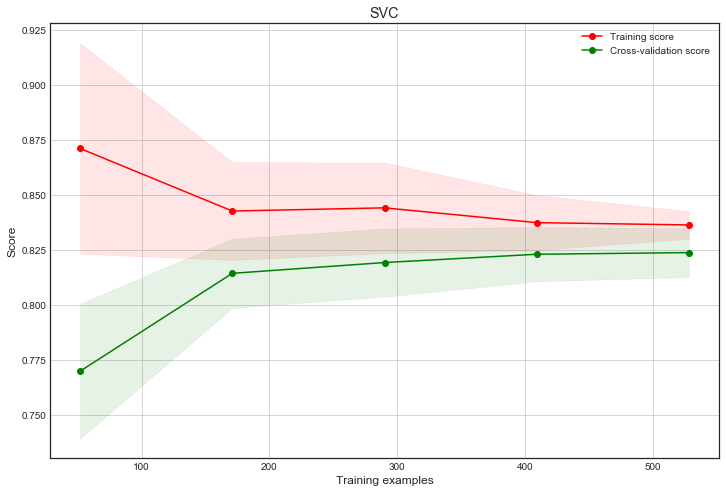

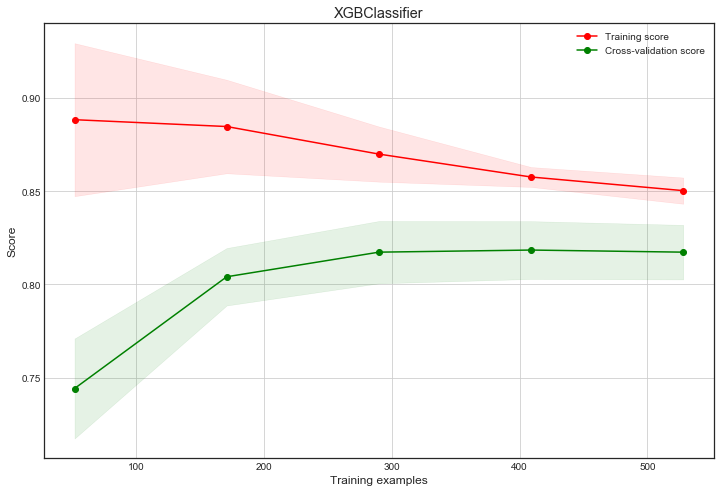

In [935]:
# draw the learning curve for every selected model.
for i in vote_set:
    g = plot_learning_curve(i[1],i[1].__class__.__name__,X_train,Y_train,cv=cv_split)

In [905]:
# Feature Importance analysis for every classifiers

In [920]:
# names = train.drop(['Survived'], axis=1).columns

# for i in vote_set:
    
#     ratios = i[1].feature_importances_

#     feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
#     feature_important = feature_important.sort_values(by=['importance'], ascending=True)
#     feature_important.plot(kind='barh', stacked=True, color=['cornflowerblue'], grid=False, figsize=(8, 5))

In [921]:
# use the votingclassifier to do the prediction.

In [923]:
# compare the hard and soft voting method.

grid_hard = ensemble.VotingClassifier(estimators = vote_set , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, X_train,Y_train, cv  = cv_split)
grid_hard.fit(X_train,Y_train)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_set , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, X_train,Y_train, cv  = cv_split)
grid_soft.fit(X_train,Y_train)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)


c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 84.56
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.23
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 3.10
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 84.19
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 81.77
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 2.63
----------


c:\users\zhaofeng shang\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [924]:
# after comparison, the hard voting is better.

In [925]:
prediction = grid_hard.predict(test)

In [933]:
output = pd.DataFrame({'PassengerId': data_val['PassengerId'], "Survived": prediction})
output.to_csv('prediction2.csv', index=False)

In [937]:
output


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
